Notebook purpose

- Sense-check and explore calculated account balances

In [27]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))
df.head(1)

Rows: 1,301,806
Users: 430


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings
0,688261,2012-01-03,777,400.0,<mdbremoved> - s/o,NaN,transfers,tsransfer,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,transfers,other account,other account,u,201201,-1451.075562,24319.220881,False


## Balances over time

Below shows median of median weekly balances.

In [24]:
def median_balance(df, account_type='current', freq='w'):
    """Calculate median balance account type."""
    return (df.loc[df.account_type == account_type]
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1)
            .groupby('date').median()
            .resample(freq).median())

In [31]:
current_account_balances = median_balance(df, account_type='current', freq='w')
savings_account_balances = median_balance(df, account_type='savings', freq='w')
credit_card_balances = median_balance(df, account_type='credit card', freq='w')
users = df.resample('w', on='date').user_id.nunique()

In [32]:
credit_card_balances

date
2013-01-06            NaN
2013-01-13            NaN
2013-01-20            NaN
2013-01-27            NaN
2013-02-03            NaN
                 ...     
2020-07-05   -1011.390076
2020-07-12    -894.089783
2020-07-19   -1354.370117
2020-07-26   -1713.210083
2020-08-02   -1317.659912
Freq: W-SUN, Name: balance, Length: 396, dtype: float32

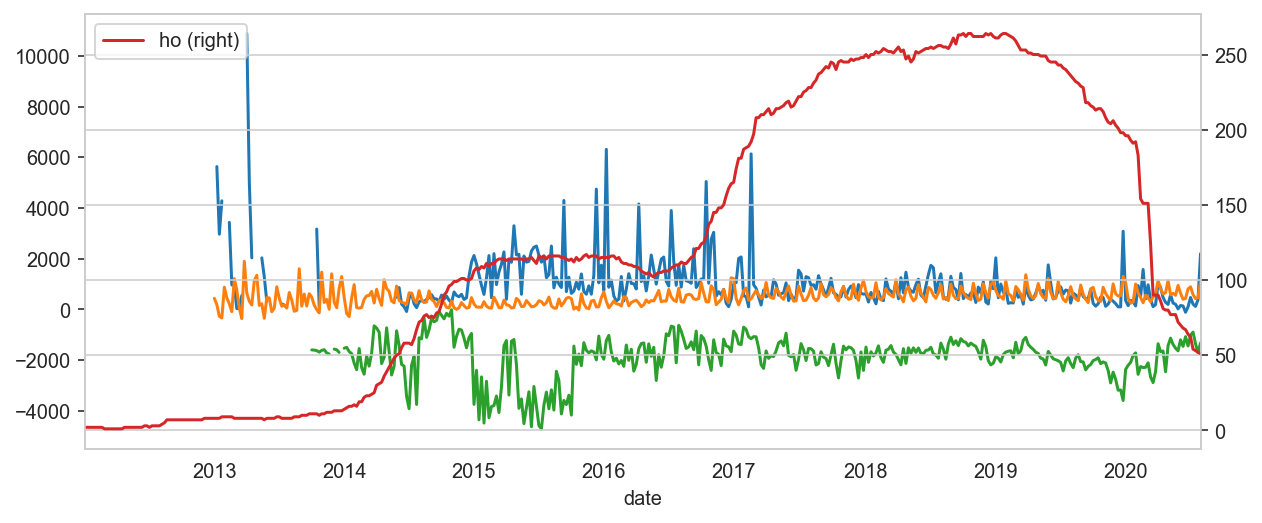

In [56]:
plotargs = dict(figsize = (10, 4))
savings_median_weekly_balance.plot(**plotargs, label='savings')
current_median_weekly_balance.plot(**plotargs, label='current')
credit_median_weekly_balance.plot(**plotargs, label='credit')
users.plot(**plotargs, secondary_y=True, label='ho')
plt.legend();

## Monthly current-account balance pattern

2018 data for monthly pattern

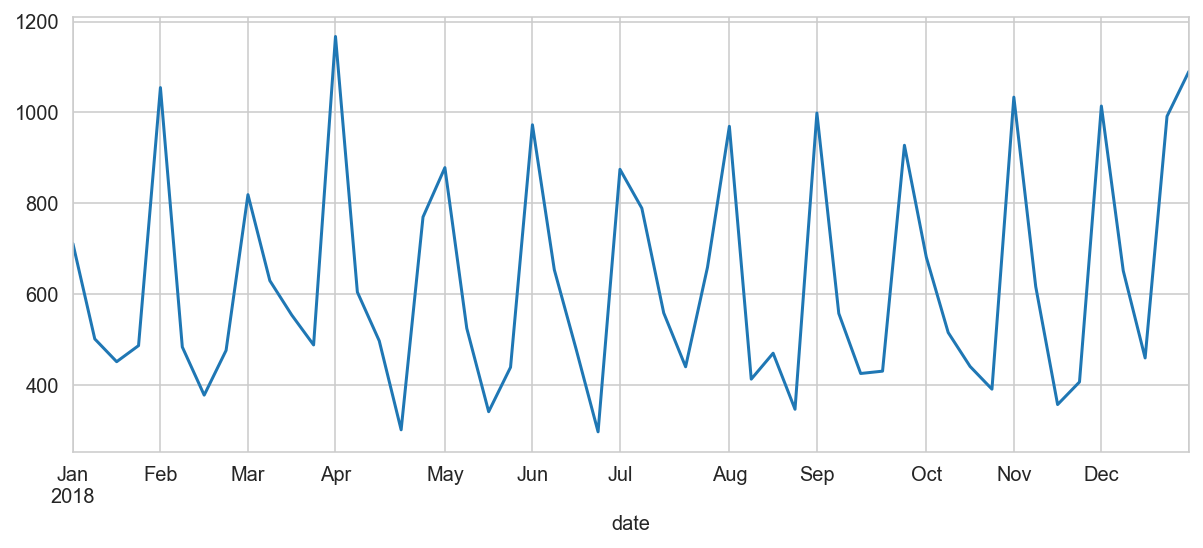

In [6]:
current_median_weekly_balance.loc['2018'].plot(**plotargs);

As expected, balances are high around salary payment dates and then decline throughout the month

## Income-scaled balances

Plot weekly median (across weekdays) of daily median current account balance divided by monthly income (across users).

In [7]:
daily_balance = (df.loc[df.account_type == 'current']
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1))

monthly_income = (df.set_index('date')
                  .groupby('user_id')
                  .resample('d').income.first()
                  .div(12))

scaled_balance = (daily_balance
                  .div(monthly_income)
                  .rename('scaled_balance'))

weekly_agg_scaled_balance = (scaled_balance
                             .resample('d', level='date').median()
                             .resample('w').median())

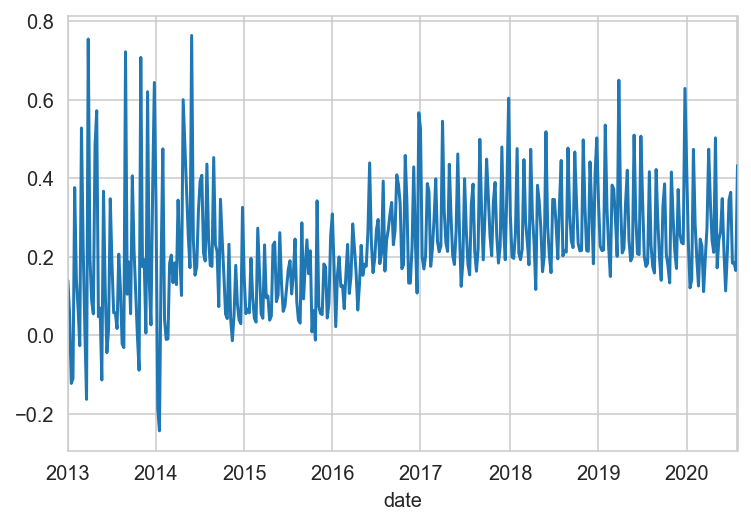

In [8]:
weekly_agg_scaled_balance.loc['2013':].plot();

Monthly pattern in 2018

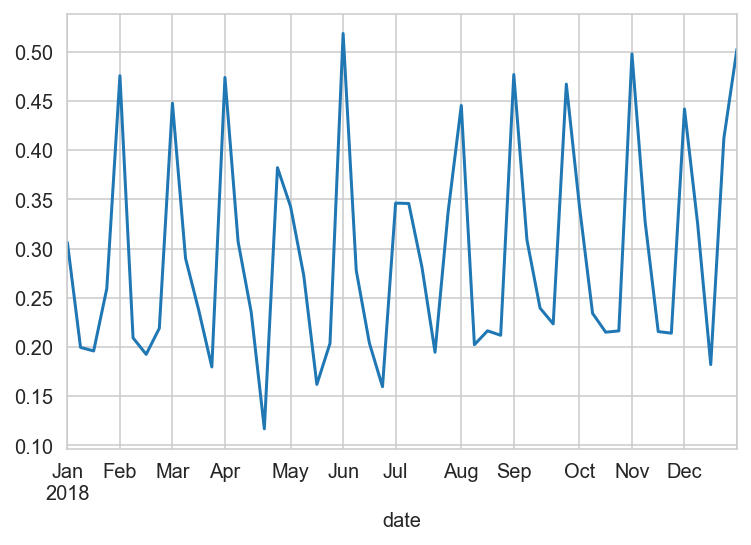

In [9]:
weekly_agg_scaled_balance.loc['2018'].plot();

## User case studies

In [31]:
SAMPLE_SIZE = df.user_id.nunique()
SAMPLE_SIZE = 2

rng = np.random.default_rng(seed=2312)
user_sample = rng.choice(df.user_id.unique(), size=SAMPLE_SIZE)
mask = df.user_id.isin(user_sample)

daily_balances = (df[mask]
                  .set_index('date')
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str'))
                  .groupby(['account_label', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id'))

daily_balances.head(2)

,account_label,user_id,date,balance
0,current-278242,84777,2014-04-04,862.249451
305,current-278244,84777,2014-08-23,430.000000


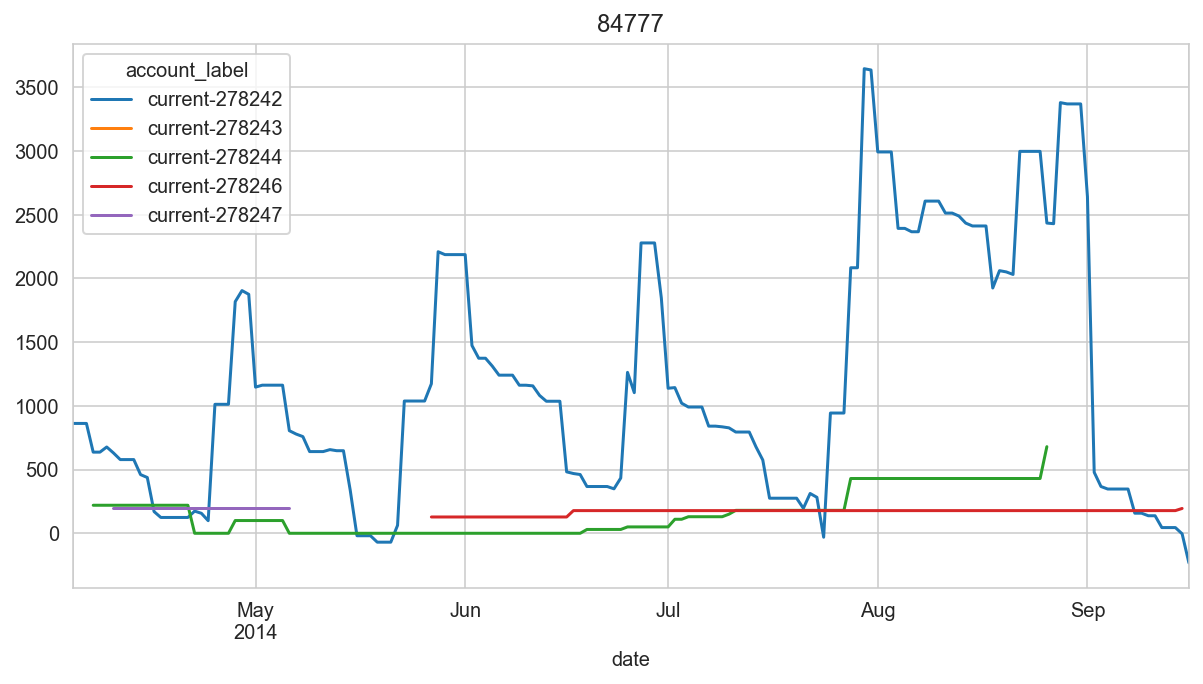

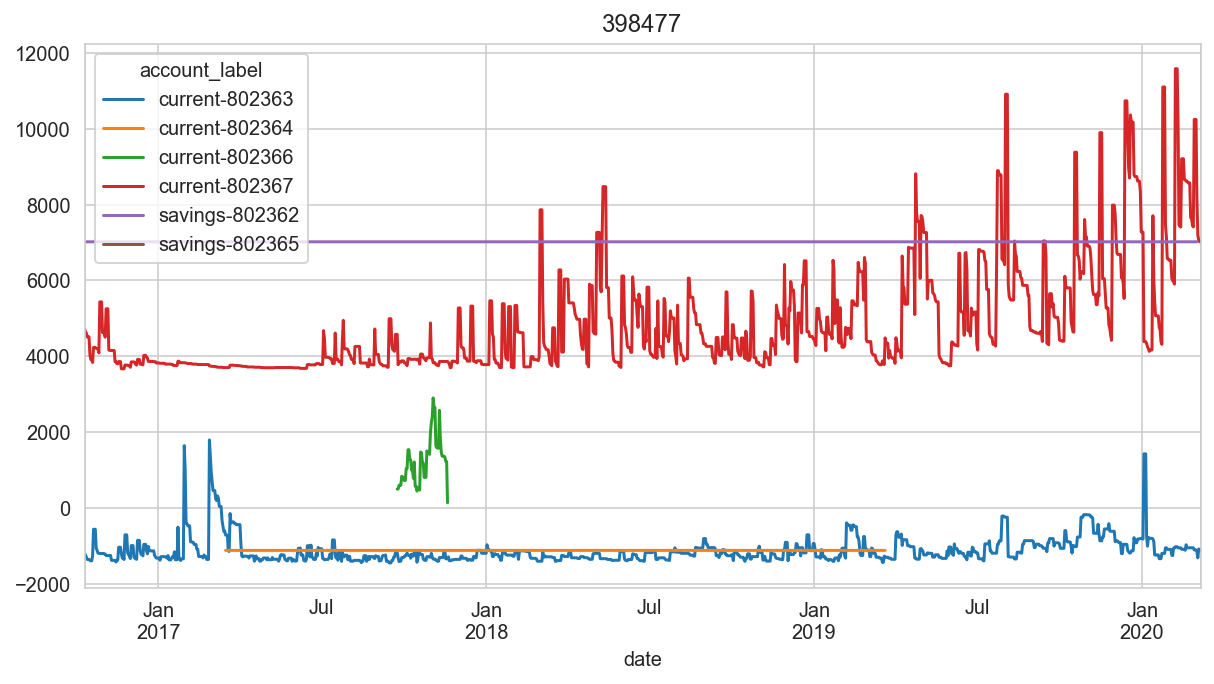

In [32]:
for id, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5), title=id);

## Savings account balances

In [21]:
savings_balances = (df[df.account_type == 'savings']
                    .assign(account_label=lambda x: 
                            x.account_id.astype('str') + '-' 
                            + x.user_id.astype('str'))
                    .set_index('date')
                    .groupby(['account_label'])
                    .resample('D').balance.first()
                    .fillna(method='ffill')
                    .dropna()
                    .reset_index())

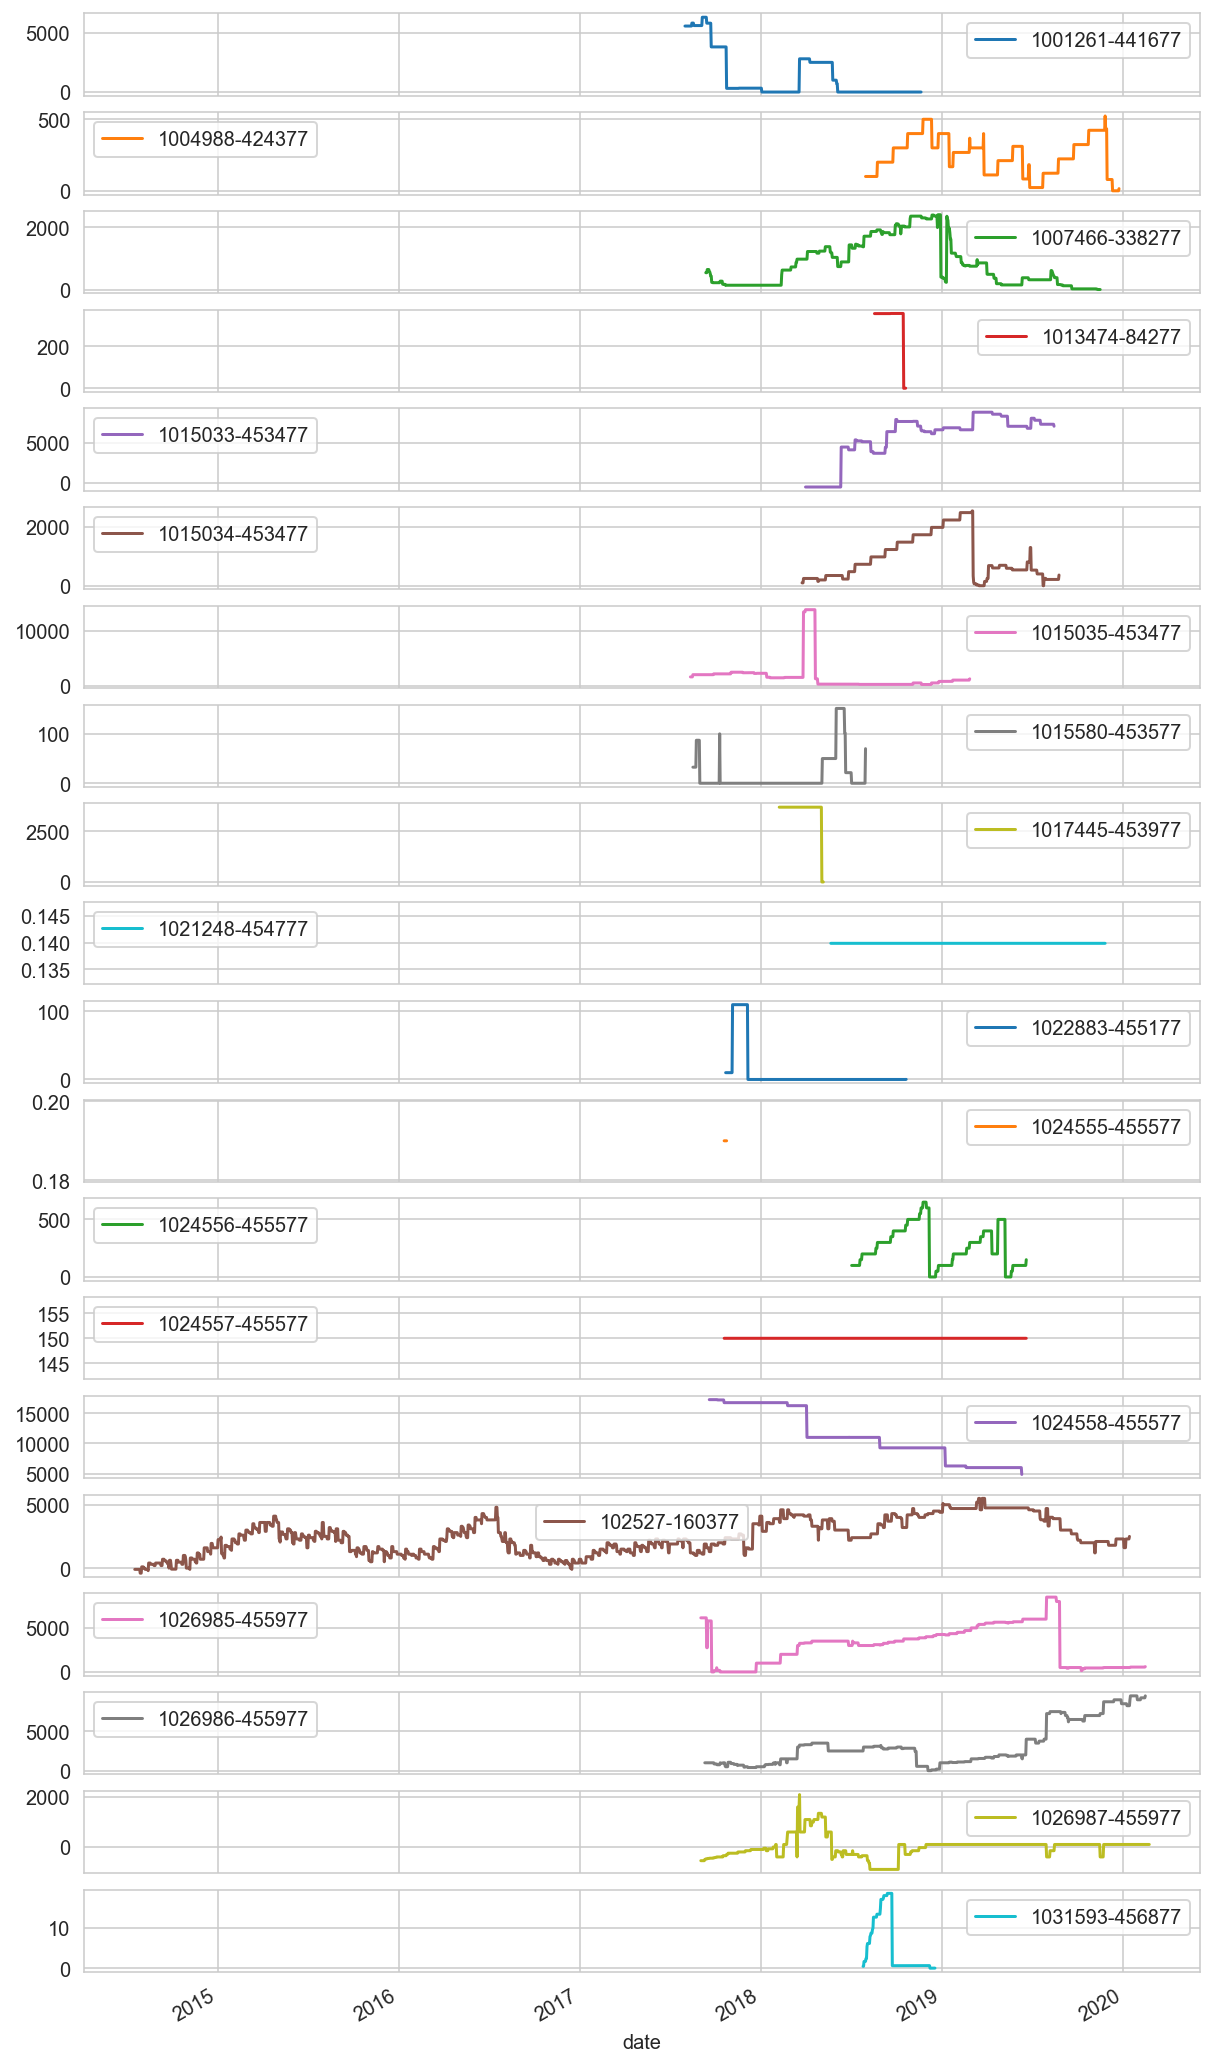

In [22]:
SAMPLE_SIZE = 20
savings_balances.pivot('date', 'account_label', 'balance').iloc[:, :SAMPLE_SIZE].plot(subplots=True, figsize=(10, 20));